In [71]:
import torch
import torch.nn as nn 
from torchvision import models, datasets, transforms
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
import os
import koreanize_matplotlib
from PIL import Image
import sys
sys.path.append(r'C:\Users\kdp\Desktop\KDW\EX_OPEN_CV\Project\MyModule')
from KDTModule import *

In [72]:
# 이미지 전처리(transform) 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),          # 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

# ImageFolder 사용
ROOT_PATH = r"C:\Users\kdp\Downloads\project"
DS = datasets.ImageFolder(root=ROOT_PATH, transform=transform)

# DataLoader
DL = DataLoader(DS, batch_size = 32, shuffle=True)

print(DS.classes)
print(f'데이터 개수 : {len(DL.dataset)}')

['1', '2', '3', '4', '5']
데이터 개수 : 2907


In [73]:
file_path = [i[0] for i in DS.imgs]
labels = [i[1] for i in DS.imgs]

In [74]:
train_path, test_path, train_labels, test_labels = train_test_split(file_path, labels, stratify=labels,
                                                                    random_state = 42, train_size = 0.8)
train_path, valid_path, train_labels, valid_labels = train_test_split(train_path, train_labels,
                                                                      stratify=train_labels,
                                                                      random_state = 42, train_size = 0.8)

In [75]:
class ImagePathDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        super().__init__()
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform != None:
            image = self.transform(image)

        # 레이블 불러오기
        label = self.labels[idx]

        return image, label

In [76]:
trainDS = ImagePathDataset(train_path, train_labels, transform=transform)
validDS = ImagePathDataset(valid_path, valid_labels, transform=transform)
testDS = ImagePathDataset(test_path, test_labels, transform=transform)

trainDL = DataLoader(trainDS, batch_size = 32)
validDL = DataLoader(validDS, batch_size = 32)
testDL = DataLoader(testDS, batch_size = 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


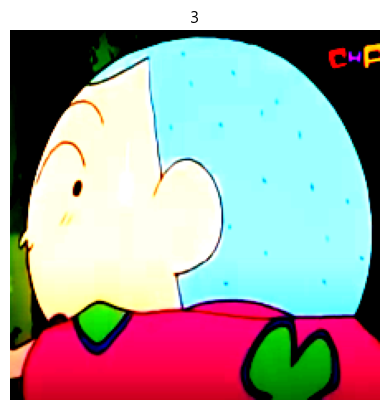

In [77]:
def draw_shin_chan(INDEX):
    name_dict = {i : DS.classes[i] for i in range(len(DS.classes))}
    plt.rcParams['font.family'] = 'Malgun Gothic'
    a = trainDL.dataset[INDEX][0].permute(1,2,0)
    plt.axis('off')
    plt.title(name_dict[trainDL.dataset[INDEX][1]])
    plt.imshow(a)
    plt.show()

draw_shin_chan(11)

In [78]:
# GPU 사용 가능 여부 확인
if torch.cuda.is_available():
    print('GPU')
    device = torch.device("cuda")
else:
    print('CPU')
    device = torch.device("cpu")

CPU


In [79]:
# 미리 학습된 ConvNext 모델 불러오기 (weight 사용)
model = models.convnext_base(pretrained=True).to(device)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 전결합층 가중치 변경하도록 설정
for param in model.classifier.parameters():
    param.requires_grad = True

model

c:\Users\kdp\anaconda3\envs\TORCH_CV_38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kdp\anaconda3\envs\TORCH_CV_38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [80]:
# 마지막 레이어 교체 (클래스 5개로 변경)
num_features = model.classifier[2].in_features # 2048
model.classifier[2] = nn.Linear(num_features, 5).to(device) 

# 손실 함수와 옵티마이저 정의
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [81]:
print(trainDL.dataset[0][0].shape)
print(trainDL.dataset[0][1])

torch.Size([3, 224, 224])
0


In [82]:
trainDL.dataset[0][0].shape

torch.Size([3, 224, 224])

In [83]:
# # 훈련
# EPOCH = 50
# SAVE_PATH = r'C:\Users\kdp\Desktop\KDW\EX_OPEN_CV\Project'

# result = training(trainDL, validDL, model, model_type = 'multiclass', optimizer = optimizer,
#                   epoch = EPOCH, endurance_cnt = 5, view_epoch = 1, num_classes = 5, SAVE_PATH = SAVE_PATH)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/50] Train : 1.1839, Test : 0.8053
[Score  : 1/50] Train : 0.5593, Test : 0.7859
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/50] Train : 0.7111, Test : 0.5905
[Score  : 2/50] Train : 0.7966, Test : 0.8463
[EPOCH] : 3에서 모델 저장 완료.
[Loss : 3/50] Train : 0.5345, Test : 0.4877
[Score  : 3/50] Train : 0.8602, Test : 0.8692
[EPOCH] : 4에서 모델 저장 완료.
[Loss : 4/50] Train : 0.4336, Test : 0.4272
[Score  : 4/50] Train : 0.8983, Test : 0.8815
[EPOCH] : 5에서 모델 저장 완료.
[Loss : 5/50] Train : 0.3661, Test : 0.3878
[Score  : 5/50] Train : 0.9168, Test : 0.8919
[EPOCH] : 6에서 모델 저장 완료.
[Loss : 6/50] Train : 0.3167, Test : 0.3605
[Score  : 6/50] Train : 0.9237, Test : 0.8942
[EPOCH] : 7에서 모델 저장 완료.
[Loss : 7/50] Train : 0.2787, Test : 0.3408
[Score  : 7/50] Train : 0.9354, Test : 0.8942
[EPOCH] : 8에서 모델 저장 완료.
[Loss : 8/50] Train : 0.2481, Test : 0.3262
[Score  : 8/50] Train : 0.9433, Test : 0.8942
[EPOCH] : 9에서 모델 저장 완료.
[Loss : 9/50] Train : 0.2229, Test : 0.3151
[Score  : 9/50] Trai

(<Figure size 1400x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='EPOCH', ylabel='Loss'>,
        <Axes: title={'center': 'Score'}, xlabel='EPOCH', ylabel='Loss'>],
       dtype=object))

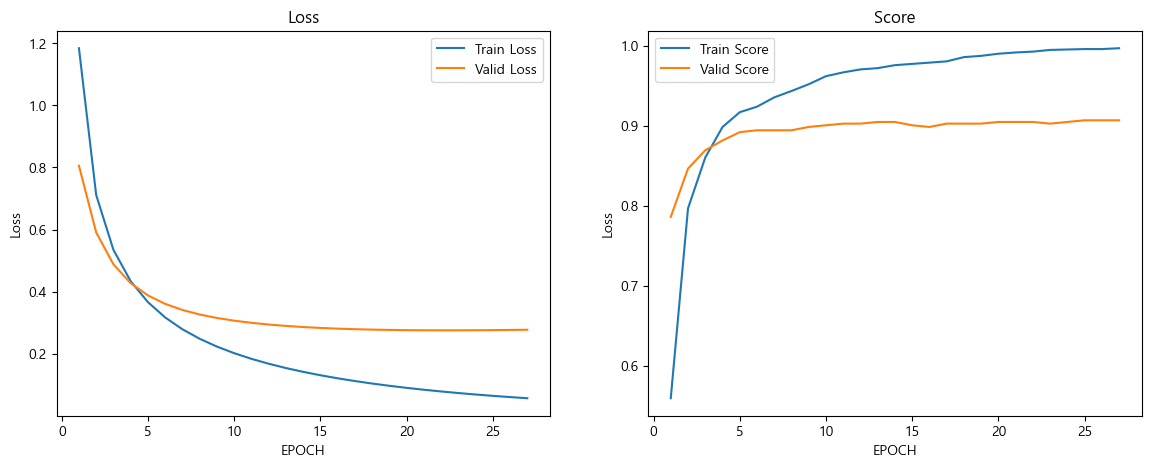

In [91]:
# 손실 및 스코어 시각화
DrawPlot(result)

In [85]:
best_model = models.convnext_base(weights=models.ConvNeXt_Base_Weights.IMAGENET1K_V1).to(device)

# 마지막 레이어를 5개의 클래스에 맞게 수정
best_model.classifier[2] = nn.Linear(best_model.classifier[2].in_features, 5)

# 저장된 가중치 로드
best_model.load_state_dict(torch.load('best_model_epoch_10.pth'))

C:\Users\kdp\AppData\Local\Temp\ipykernel_25912\1698554510.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_model_epoch_10.pth

<All keys matched successfully>

In [86]:
input_data = next(iter(trainDL))


In [87]:
pred_value = torch.argmax(best_model(input_data[0]), dim=1).cpu()
pred_value

tensor([0, 0, 3, 1, 0, 0, 4, 2, 1, 1, 2, 2, 2, 3, 2, 1, 1, 1, 0, 4, 2, 0, 1, 3,
        4, 1, 2, 0, 3, 3, 0, 2])

In [88]:
real_value = input_data[1].cpu()
real_value

tensor([0, 0, 3, 1, 0, 0, 4, 2, 1, 1, 3, 2, 2, 3, 2, 1, 1, 1, 4, 4, 2, 0, 1, 3,
        4, 1, 2, 0, 3, 3, 0, 2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


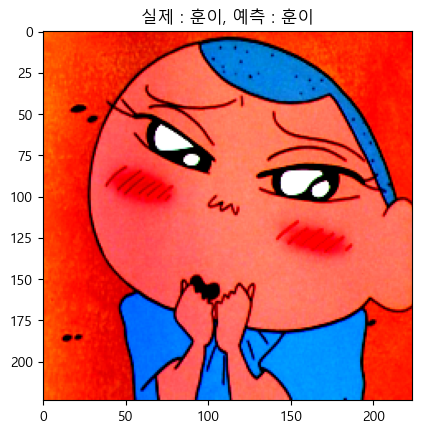

In [89]:
INDEX = 20 # 0 ~ 31

name_dict = {0 : '짱구', 1 : '철수', 2: '훈이' , 3 : '맹구', 4 : '유리'}
pred_name = name_dict[pred_value[INDEX].cpu().item()]
real_name = name_dict[input_data[1][INDEX].cpu().item()]
plt.imshow(input_data[0][INDEX].cpu().permute(1,2,0))
plt.title(f'실제 : {real_name}, 예측 : {pred_name}')
plt.show()